In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
from jax import jit, value_and_grad, vmap
from jax.tree_util import tree_structure
import optax
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle as p
import time as t

In [3]:
import poppy
import astropy.units as u

In [4]:
import equinox as eqx

---
# Base Classes

In [5]:
# Base Classes
class Layer(eqx.Module):
    """
    Base Layer class
    Can optionally pass in 'function' in order to facilitate parameterised planes
    Can optionally pass in 'static' to automatically freeze in the parameters
    """
    size_in: int = eqx.static_field()
    size_out: int = eqx.static_field()
    
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out

class OpticalSystem(eqx.Module):
    """
    Base class defining some optical system
    layers must be a list of Layer objects
    Each layer object can either be some optical operation, 
    transform, or NN type layer
    """
    layers: list 
    
    def __init__(self, layers):
        self.layers = layers 
        
    def __call__(self, wavel):
        wavefront = self.layers[0](wavel) # Always assumed to be CreateWavefront layer
        for i in range(1, len(self.layers)):
            wavefront = self.layers[i](wavefront, wavel)
        return np.abs(wavefront)**2

---

## Layer Sub-Classes

In [6]:
class CreateWavefront(Layer):
    """
    Initialises an input wavefront
    x and y should be in radians (measured from the optical axis)
        How to pass in aperture to this robustly? As a property of the osys?
        What if we want to optimise the aperture size? 
        Shuould this exist outside of the system?
        Always propagate on axis and and shift with the offset term in MFT?
    To Do: Test this properly
    """
    x: float
    y: float
    aperture: float
    
    def __init__(self, size):
        """
        Defaults the aperture size to 1
        """
        self.size_in = size
        self.size_out = size
        self.x = 0.
        self.y = 0.
        self.aperture = 0
    
    def __call__(self, wavel):
        """
        x and y are assumed to be in radiands deivation from the optical
        axis
        aperture is assumed to be in meters
        """

        npix = self.size_in
        x, y = self.x, self.y
        aperture = self.aperture

        rmax = np.hypot(x, y)
        phi_rot = np.arctan2(y, x)
        opd_max = aperture * np.sin(rmax)
        phase_max = opd_to_phase(opd_max, wavel)

        # Figure out which one of these is right
        phase_slope = np.linspace(0, phase_max, npix, endpoint=False)
        phase_array = np.tile(phase_slope, [npix, 1])

        xs = np.linspace(0, np.pi/4, npix, endpoint=False)
        XX, YY = np.meshgrid(xs, xs)
        RR = np.hypot(XX, YY)
        PHI = np.arctan2(YY, XX) - phi_rot
        phase_out = rmax * RR * np.sin(PHI)
        wavefront_out = np.ones([npix, npix]) * np.exp(1j * phase_out)

        return wavefront_out
    
class NormaliseWavefront(Layer):
    """
    Normalises the input wavefront
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, wavefront, dummy_wavel):
        norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
        norm_wavefront = wavefront/norm_factor
        return norm_wavefront
    
class MFT(Layer):
    """
    Matches poppy but assumes square
    """
    wavel_scale: float = eqx.static_field()    
    
    def __init__(self, size_in, size_out, wavel_scale):
        self.size_in = size_in
        self.size_out = size_out
        self.wavel_scale = wavel_scale
        
    def __call__(self, wavefront, wavel):
        """
        Should we add offset here too?
        I have removed it but we have the code needed in the old notebooks
        """
        npup, npix = self.size_in, self.size_out
        nlamD = self.wavel_scale / wavel
        
        dX = 1.0 / float(npup)
        dU = nlamD / float(npix)
        Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0 + 0.5) * dX
        Us = (np.arange(npix, dtype=float) - float(npix) / 2.0 + 0.5) * dU
        XU = np.outer(Xs, Us)
        expXU = np.exp(-2.0 * np.pi * 1j * XU)

        # Note: Can casue overflow issues on 32-bit
        norm_coeff = np.sqrt((nlamD**2) / (npup**2 * npix**2)) 

        # Perform MFT
        t1 = np.dot(expXU.T, wavefront)
        t2 = np.dot(t1, expXU)
        return norm_coeff * t2
    
class AddPhase(Layer):
    """
    Adds an array of values to the input wavefront
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, complex_array, dummy_wavel):
        
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array) + self.array
        return amplitude * np.exp(1j*phase)
    
class ApplyOPD(Layer):
    """
    Adds an array of phase values to the input wavefront calculated from the OPD
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, complex_array, wavel):
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array)
        phase_in = self._opd_to_phase(self.array, wavel)
        phase_out = phase + phase_in
        return amplitude * np.exp(1j*phase_out)
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
class ApplyZernike(Layer):
    """
    Adds an array of phase values to the input wavefront calculated from the OPD
    """
    nterms: int = eqx.static_field()
    basis: jax.numpy.ndarray = eqx.static_field()
    coefficients: jax.numpy.ndarray
    
    def __init__(self, size, nterms, coefficients):
        self.size_in = size
        self.size_out = size
        self.nterms = nterms
        self.coefficients = coefficients
        # Load basis
        self.basis = np.array(np.nan_to_num(
            poppy.zernike.zernike_basis(nterms=nterms+3, npix=size)[3:])).T
        print("Note Zernike Ignores Piston Tip Tilt")
        
    def __call__(self, complex_array, wavel):
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array)
        zernike_opd = np.dot(self.basis, self.coefficients)
        zernike_phase = self._opd_to_phase(zernike_opd, wavel)
        phase_out = phase + zernike_phase
        return amplitude * np.exp(1j*phase_out)
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
    def get_total_opd(self):
        return np.dot(self.basis, self.coefficients)

In [7]:
class MultiplyArray(Layer):
    """
    Multiplies the input wavefront by an array
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, array, dummy_wavel):
        return np.multiply(array, self.array)

class AddScalar(Layer):
    """
    Add a scalar to the input wavefront
    """
    value: float
    def __init__(self, size, value):
        self.size_in = size
        self.size_out = size
        self.value = value
        
    def __call__(self, array, dummy_wavel):
        return np.add(array, self.value) 

class AddArray(Layer):
    """
    Adds an array of values to the input wavefront
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, array, dummy_wavel):
        return np.add(array, self.array)
    
class MultiplyScalar(Layer):
    """
    Multiplies the input wavefront by a scalar
    """
    value: float
    def __init__(self, size, value):
        self.size_in = size
        self.size_out = size
        self.value = value
        
    def __call__(self, array, dummy_wavel):
        return np.multiply(array, self.value) 

    

--- 

## Functions

In [8]:
def FFT(array, dummy_wavel):
    """
    Performs normalisation matching poppy
    """
    norm = array.shape[0]
    array_out = norm * np.fft.fftshift( np.fft.ifft2(array) )
    return array_out 
    
def IFFT(array, dummy_wavel):
    """
    Performs normalisation matching poppy
    """
    norm = 1./array.shape[0]
    array_out = norm * np.fft.fft2( np.fft.ifftshift(array) )
    return array_out

# def NormaliseWavefront(wavefront, dummy_wavel):
#     """
#     Normalises the input wavefront
#     """
#     norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
#     norm_wavefront = wavefront/norm_factor
#     return norm_wavefront

def InvertXY(array, dummy_wavel):
    """
    Layer for axis invertions
    """
    return array[::-1, ::-1]
    
def InvertX(array, dummy_wavel):
    """
    Layer for axis invertions
    """
    return array[:, ::-1]
    
def InvertY(array, dummy_wavel):
    """
    Layer for axis invertions
    """
    return array[::-1]

# def Pad(array, size_out):
#     """
#     Pads the input to the given size
#     Places the array in the center
#     """
#     c, s = size_out//2, array.shape[0]//2
#     padded = np.zeros([size_out, size_out], dtype=array.dtype)
#     return padded.at[c-s:c+s, c-s:c+s].set(array)
    
# def Crop(array, size_out):
#     """
#     Crops the input to the given size
#     Crops from the center
#     """
#     c, s = array.shape[0]//2, size_out//2
#     return array[c-s:c+s, c-s:c+s]

In [9]:
# Helper functions
def opd_to_phase(opd, wavel):
    return 2*np.pi*opd/wavel

def phase_to_opd(phase, wavel):
    return (phase * wavel)/(2*np.pi)

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = np.linspace(-c, c, size, endpoint=False)
    Xs, Ys = np.meshgrid(xs, xs)
    Rs = np.hypot(Xs, Ys)
    
    if radius is None:
        aperture = np.where(Rs > c, 0, np.ones([size, size]))
    else:
        aperture = np.where(Rs > radius, 0, np.ones([size, size]))
    return aperture

def get_toliman_pupil(size, path=None, asymmetric=False):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    from scipy.ndimage import zoom
    if path is None:
        if asymmetric is False:
            toliman_pupil = np.load("Toliman_pupil.npy")
    else:
        if asymmetric is False:
            toliman_pupil = np.load("{}/Toliman_pupil.npy".format(path))
        
    phase = np.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * np.exp(1j * phase_scaled)
    return toliman_pupil_out

def create_aperture(npix):
    # Create aperture
    xs = np.arange(-npix//2, npix//2)
    XX, YY = np.meshgrid(xs, xs)
    RR = np.hypot(XX, YY)
    aperture = RR < npix//2
    return aperture

def create_aperture_asym(npix):
    # Create aperture
    xs = np.arange(-npix//2, npix//2)
    XX, YY = np.meshgrid(xs, xs)
    RR = np.hypot(XX, YY)
    aperture = RR < npix//2
    
    c = npix//2
    s = c//3
    aperture = aperture.at[c-s:c+s, :c].set(0)
    return aperture

---

### Osys creation

Define some osys by a list of layers

In [317]:
npix = 512
wavel_scale = 5e-4

In [318]:
min_wavel = 5.45e-6
max_wavel = 6.45e-6
mean_wavel = (max_wavel + min_wavel)/2
nwavels = 5
wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [320]:
# For Toliman Phase-Ret
aperture = create_aperture(npix)
pupil_phase = np.angle(get_toliman_pupil(npix, path='..'))
opd_true = phase_to_opd(pupil_phase, mean_wavel)
onp.random.seed(0)
opd_start = phase_to_opd(1e-2*np.array(2*np.pi*onp.random.rand(npix**2)).reshape([npix, npix]), mean_wavel)
# opd_start = phase_to_opd(np.array(onp.random.normal(loc=np.pi/4, scale=np.pi/40, size=[npix, npix])), mean_wavel)
# opd_start = np.zeros([npix, npix])

In [322]:
# Target Model
layers = [CreateWavefront(npix),                         # Wavefront creation
          MultiplyArray(npix, aperture),                 # Apply aperture
          NormaliseWavefront(npix),                      # Normalise input power
          ApplyOPD(npix, opd_true),                      # Apply Phase Screen
          MFT(npix, npix, wavel_scale)]                  # Tranform to focal plane

# Optimisation Model
layers_init = [CreateWavefront(npix),                    # Wavefront creation
               MultiplyArray(npix, aperture),            # Apply aperture
               NormaliseWavefront(npix),                 # Normalise input power
               ApplyOPD(npix, opd_start),                # Apply Phase Screen
               MFT(npix, npix, wavel_scale)]             # Tranform to focal plane

In [323]:
ideal_model = OpticalSystem(layers)
model = OpticalSystem(layers_init)

In [324]:
data = vmap(ideal_model)(wavels).sum(0)
initial_psf = vmap(model)(wavels).sum(0)

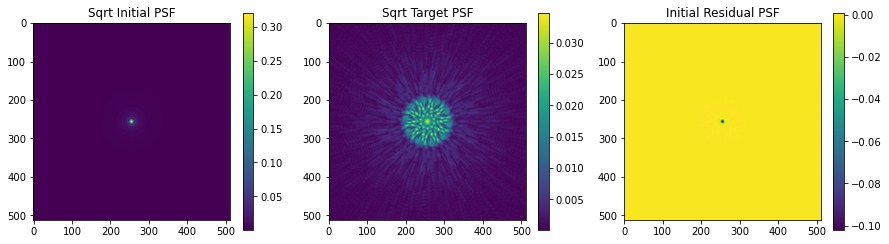

In [326]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Sqrt Initial PSF")
plt.imshow(initial_psf**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Sqrt Target PSF")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Initial Residual PSF")
plt.imshow(data-initial_psf)
plt.colorbar()
plt.show()

## Optimisaion

In [327]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_func(model, wavels, data):
    psf = vmap(model)(wavels).sum(0)
    # return np.sum((psf - data)**2)
    return np.sum(np.abs(psf - data)) # Use MAE not MSE

In [369]:
model = OpticalSystem(layers_init)
optim = optax.adam(2e-7)
opt_state = optim.init(model)

errors, grads_out = [], []
for i in tqdm(range(2000)):
    if i == 1000:
        optim = optax.adam(1e-7)
        opt_state = optim.init(model)
    loss, grads = loss_func(model, wavels, data)    
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    errors.append(loss)
    grads_out.append(grads)

  0%|          | 0/2000 [00:00<?, ?it/s]

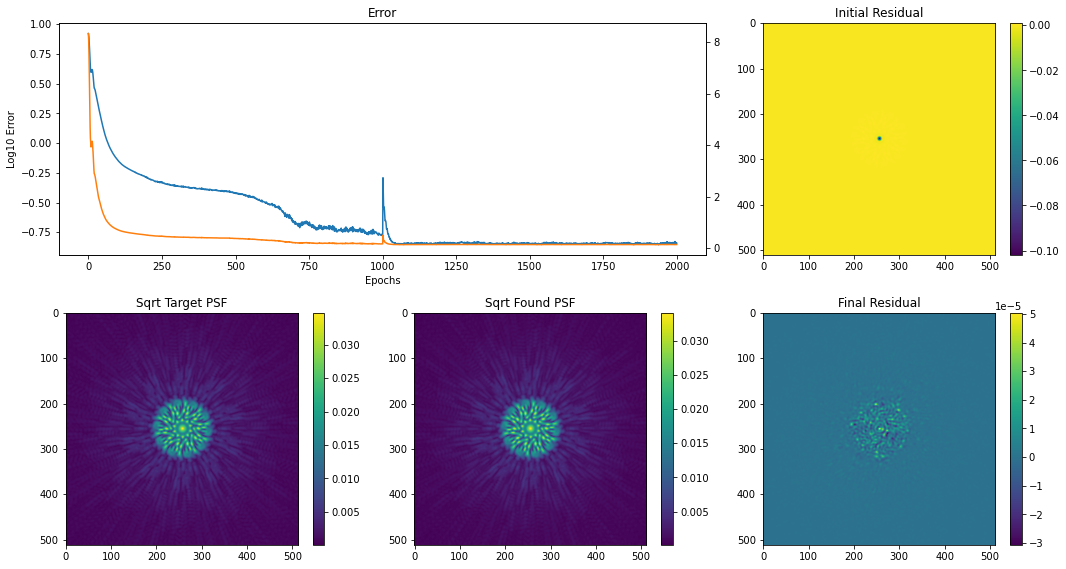

In [370]:
final_psf = vmap(model)(wavels).sum(0)
residual = data - final_psf
initial_residual = data - initial_psf

vmin = np.min(initial_residual)
vmax = np.max(initial_residual)

plt.figure(figsize=(15, 8))
ax = plt.subplot(2, 3, (1,2))
plt.title("Error")
plt.plot(np.arange(len(errors)), np.log10(np.array(errors)))
plt.xlabel("Epochs")
plt.ylabel("Log10 Error")
ax2 = ax.twinx()
ax2.plot(np.arange(len(errors)), np.array(errors), c='tab:orange')

plt.subplot(2, 3, 3)
plt.title("Initial Residual")
plt.imshow(initial_residual)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Sqrt Target PSF")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Sqrt Found PSF")
im = plt.imshow(final_psf**0.5)
cbar = plt.colorbar(im)
plt.subplot(2, 3, 6)

plt.title("Final Residual")
plt.imshow(residual)#, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.tight_layout()
plt.show()

In [377]:
opd_out = model.layers[3].array
opd_out -= np.min(opd_out) # Normalise 
residual = opd_true - opd_out

# RMSE_inital = opd_to_phase(np.sqrt(np.mean((opd_true-opd_start)**2)), mean_wavel)
# RMSE_final  = opd_to_phase(np.sqrt(np.mean(residual**2)), mean_wavel)
# print("Initial RMS Phase Error: {}".format(RMSE_inital))
# print("Final RMS Phase Error:   {}".format(RMSE_final))

phases_true = opd_to_phase(opd_in, mean_wavel)
phases_out = (opd_to_phase(opd_out, mean_wavel)+0.5)%(2*np.pi)
phase_residual = phases_true - phases_out

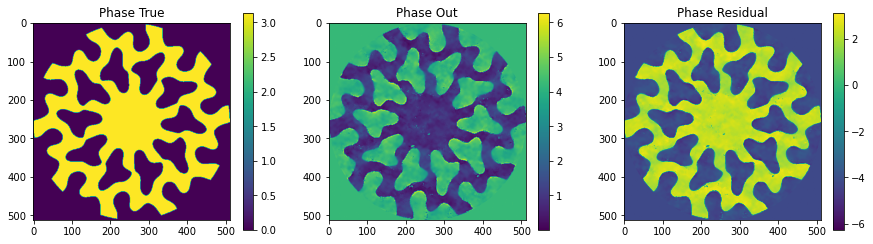

In [378]:
# plt.figure(figsize=(15, 4))
# plt.subplot(1, 3, 1)
# plt.title("OPD True")
# plt.imshow(opd_true)#, vmin=vmin, vmax=vmax)
# plt.colorbar()

# plt.subplot(1, 3, 2)
# plt.imshow(opd_out)#, vmin=vmin, vmax=vmax)
# plt.title("OPD out")
# plt.colorbar()

# plt.subplot(1, 3, 3)
# plt.imshow(residual)#, vmin=vmin, vmax=vmax)
# plt.title("OPD residual")
# plt.colorbar()
# plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Phase True")
plt.imshow(phases_true)#, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(phases_out)#, vmin=vmin, vmax=vmax)
plt.title("Phase Out")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(phase_residual)#, vmin=vmin, vmax=vmax)
plt.title("Phase Residual")
plt.colorbar()
plt.show()